## Image Masking

This notebook is designed to help create masks for various data sets, which are relevant for:

1. Removing parts of the image that aren't important in the analysis;
2. Correcting for any light gradients present in the image; and
2. Detecting particles that are close to the boundaries and could potentially have wall contacts.

The areas that actively need to be edited are denoted as such, and the rest of the notebook
can be left as it is (unless larger changes need to be made, other mask elements need to be added, etc.).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

from PIL import Image

# My custom photoelastic toolbox
try:
    # If the package is installed system-wide via pip, we can just do this
    import pepe
except:
    # Otherwise, we need to manually add the path to the library
    # If you don't have a copy of the library locally, it can be fetched
    # with: git clone https://github.com/Jfeatherstone/pepe
    # You would then add the path to the fetched `pepe` folder as below.
    import sys
    sys.path.append('/eno/jdfeathe/pepe/')
    #sys.path.append('/home/jack//workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import checkImageType, crossMask, circularMask, rectMask, mergeMasks, lightCorrectionDiff

There are 3 masks that are created below:

1. A complete mask over the image, used in the majority of the image processing;
2. A mask denoting the horizontal region over which to calculate the horizontal light gradient; and
3. A mask denoting the vertical region over which to calculate the vertical light gradient.

The first mask is the most important, and is generally constructed by adding together masks of various shapes.
The currently available methods (defined in [`pepe.preprocess.Mask`](https://jfeatherstone.github.io/pepe/pepe/preprocess/Mask.html)) are:

- `pepe.preprocess.circularMask()`

- `pepe.preprocess.crossMask()`

- `pepe.preprocess.rectMask()`

- `pepe.preprocess.mergeMasks()`

Even these limited shapes can create quite complex masks using several logical (`AND`, `OR`, `NOT`, etc.) operations.

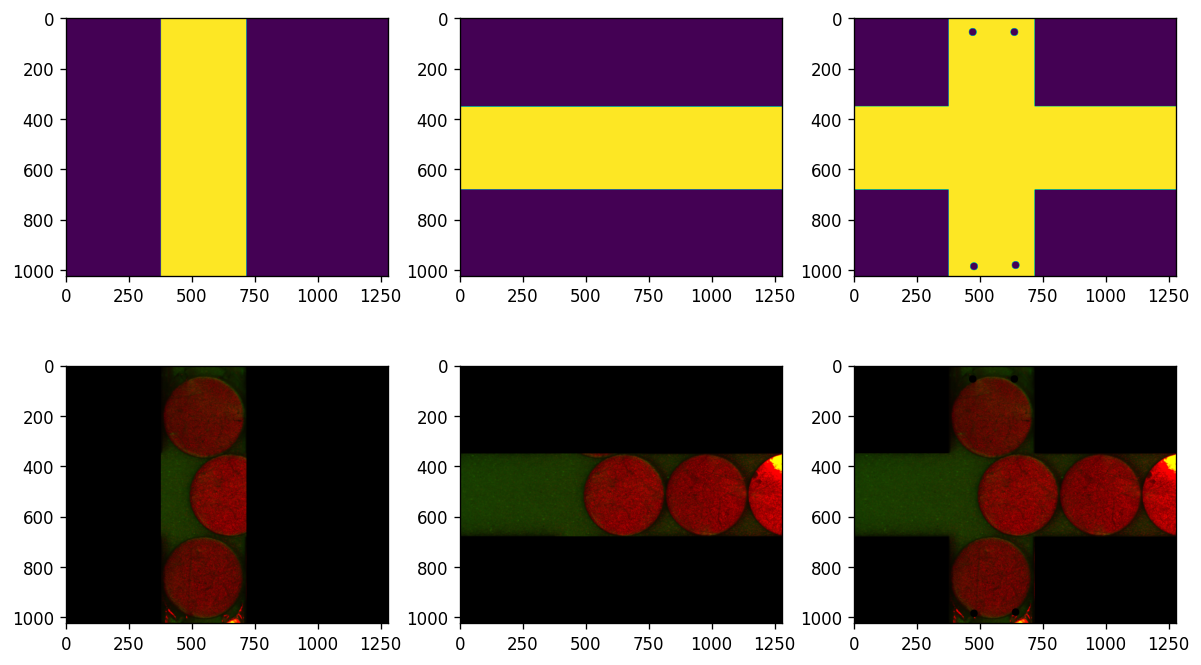

In [6]:
# Parameters to edit
#########################

# This should be the (ideally absolute) path to the SpaceJam data folder
#rootFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
rootFolder = '/eno/jdfeathe/DATA/SpaceJam/' # Should end in a '/'
# This should be the name of a directory in rootFolder
dataSet = '2022-03-16_Medium' 

# The x and y bounds for the cross-shaped mask
maskXBounds = [375, 715] # Found manually
maskYBounds = [350, 680] # Found manually

# The centers of the pins for the boundary particles (to localize forces)
pegCenters = [[55, 470], [55, 635], [985, 475], [980, 640]] # Found manually
pegRadii = 15

#########################
# No need to edit below this line (usually)

sampleImage = checkImageType(rootFolder + dataSet + '/frame0001.bmp') 

# For light correction, we want two separate images, one vertical and one horizontal
height, width = sampleImage.shape[:2]
verticalMask = np.array([[int(i < maskXBounds[1] and i > maskXBounds[0]) for i in range(width)] for j in range(height)], dtype=np.uint8)
horizontalMask = np.array(np.transpose([[int(i < maskYBounds[1] and i > maskYBounds[0]) for i in range(height)] for j in range(width)]), dtype=np.uint8)

verticalMask = np.repeat(verticalMask[:,:,None], 3, axis=-1)
horizontalMask = np.repeat(horizontalMask[:,:,None], 3, axis=-1)

fullMask = crossMask(sampleImage.shape, xlim=np.array(maskXBounds), ylim=np.array(maskYBounds))

for i in range(len(pegCenters)):
    fullMask = fullMask - circularMask(sampleImage.shape, np.array(pegCenters[i]), pegRadii)
    
fullMask = np.array(fullMask > 0, dtype=np.uint8)

fig, ax = plt.subplots(2, 3, figsize=(10,6))

ax[0,0].imshow(verticalMask[:,:,0])
ax[0,1].imshow(horizontalMask[:,:,0])
ax[0,2].imshow(fullMask[:,:,0])

ax[1,0].imshow(verticalMask * sampleImage)
ax[1,1].imshow(horizontalMask * sampleImage)
ax[1,2].imshow(fullMask * sampleImage)


fig.tight_layout()
plt.show()

Assuming you are satisfied with the results above, the following cell will save the masks as image files
to be used later on in the analysis process.

In [7]:
# This will give the date, assuming the files are named according to the format:
# <date>_<identifyer>[_<number>]
dateStr = dataSet.split('_')[0]

fullMaskImg = Image.fromarray(fullMask)
verticalMaskImg = Image.fromarray(verticalMask)
horizontalMaskImg = Image.fromarray(horizontalMask)

fullMaskImg.save(f'Masks/{dateStr}_FullMask.bmp')
verticalMaskImg.save(f'Masks/{dateStr}_VerticalMask.bmp')
horizontalMaskImg.save(f'Masks/{dateStr}_HorizontalMask.bmp')

print(f'Saved files as Masks/{dateStr}_<mask>.bmp')

Saved files as Masks/2022-03-16_<mask>.bmp
